## Hamiltonian Monte Carlo

Functions:
- Normal: returns the gaussian PDF with given point, mean and variance
- neg_log_prob: returns the neg log of the gaussian
- func: unknown function to maximize
- leapfrog_step: returns the updated parameters q1, p1
- metropolis_acceptance: calculates the ratio and returns True if the trajectory was acepted
- HMC: Produces an array of samples, of trajectories and a boolean array if the traj is accepted or not

In [257]:
import numpy as np
import random
import scipy.stats as st
import scipy.integrate as integ
import matplotlib.pyplot as plt
from tqdm import tqdm

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def func(x):
    return 0.2*normal(x, 0, 0.5) + 0.8*normal(x, 4, 0.5)

def leapfrog_step(q1, p1, step_size, dVdQ):
    p1 -= step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 
    p1 -= step_size*dVdQ/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def metropolis_acceptance(q0, p0, q1, p1):
    q0_nlp = func(q0)
    q1_nlp = func(q1)

    p0_nlp = normal(x=p0,mu=0,sigma=1)
    p1_nlp = normal(x=p1,mu=0,sigma=1)

    target = q1_nlp/q0_nlp # P(q1)/P(q0)
    adjustment = p1_nlp/p0_nlp # P(p1)/P(p0)
    acceptance = target*adjustment
    
    event = random.uniform(0,1)
    return event <= acceptance

def HMC(path_len=1,step_size=0.1,initial_position=0.1, epsilon = 0.01, epochs=20_000):
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    momentum_dist = st.norm(0, 1)
    samples = [initial_position]
    trajectories = []
    success = [] 
    # generate samples
    for e in tqdm(range(epochs)):
        q0 = np.copy(samples[-1])
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs()        
        p1 = np.copy(p0) 
        traj = [[q0, p0]]
        dVdQ = (-1*np.log(func(q0 + epsilon)) + np.log(func(q0)))/epsilon
        
        # leapfrog integration 
        for s in range(steps): 
            q1, p1 = leapfrog_step(q1, p1, step_size, dVdQ)
            traj.append(np.array([q1, p1]))  
        
        #flip momentum for reversibility 
        p1 = -1*p1     
        trajectories.append(traj)
        
        #metropolis acceptance
        accepted = metropolis_acceptance(q0, p0, q1, p1)
        
        #Decide acceptance or refusal
        if accepted:
            samples.append(q1)
            success.append(True)
        else:
            samples.append(q0)
            success.append(False)
    
    return np.array(samples[1:]), np.array(trajectories), np.array(success)

### Testing
Run HMC and plots histogram of ALL THE SAMPLED POINTS. Quindi se sei al punto 3 e generi 5 triettorie tutte rifiutate comunque il punto 3 compare 5 volte nella statistica dei trials, é giusto?

100%|██████████| 20000/20000 [00:02<00:00, 7888.80it/s]


Rate of accepted trajectories: 6967/20000 = 0.34835


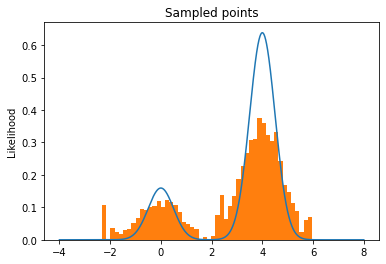

In [262]:
epochs = 20000
path_len = .8
step_size = 0.1
epsilon = 0.01

trial, trajectories, success= HMC(path_len=path_len,step_size=step_size, epsilon = epsilon, epochs = epochs)

trial = np.array(trial)
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

accepted = np.sum(success)
print('Rate of accepted trajectories: {}/{} = {}'.format(accepted, epochs, accepted/epochs))
plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=50)
plt.title('Sampled points')
plt.ylabel('Likelihood')
plt.show()    

We plot only the points obtained from an accepted trajectories (so there is no over counting)

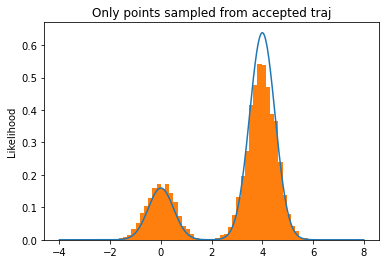

In [263]:
trial_accepted = trial[success == True]
lines = np.linspace(-4,8,10_000)
normal_curve = [func(l) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial_accepted,density=True,bins=50)
plt.title('Only points sampled from accepted traj')
plt.ylabel('Likelihood')
plt.show()   

Last 100 sampled points

(array([ 3.,  8., 10., 20., 15., 18.,  7.,  0.,  4., 15.]),
 array([3.02737781, 3.24827539, 3.46917296, 3.69007053, 3.91096811,
        4.13186568, 4.35276325, 4.57366082, 4.7945584 , 5.01545597,
        5.23635354]),
 <BarContainer object of 10 artists>)

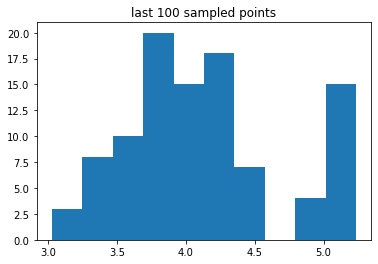

In [264]:
fig = plt.figure()
plt.title('last 100 sampled points')
plt.hist(trial[len(trial)-100:])

### Plotting
We plot the likelihood over the phase space: (q, p) to visualize the first and last trajectories.

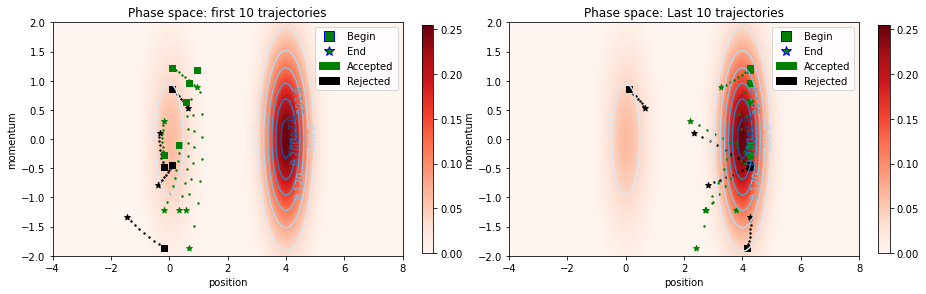

In [265]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

how_many_traj = 10


x = np.linspace(-4, 8, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z1 = func(X)
Z2 = normal(Y, 0, 1)
Z = Z1*Z2

fig, axes = plt.subplots(1, 2, figsize = (15, 9))
ax1 = axes[0]
ax2 = axes[1]

#------------ FIRST PLOT ----------------------#
ax1.set_xlabel('position')
ax1.set_ylabel('momentum')
CS = ax1.contour(X, Y, Z, cmap = 'Blues')
ax1.clabel(CS, inline=True, fontsize=10)
im = ax1.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], aspect = 2)
ax1.set_title('Phase space: first {} trajectories'.format(how_many_traj))

for i in range(how_many_traj):
    if np.any(trajectories[i,:, 1]<-2):
        continue
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax1.scatter(trajectories[i, :,0], trajectories[i, :,1], s = 2, color = c)
    begin = ax1.scatter(trajectories[i, 0 ,0], trajectories[i, 0,1], marker = 's', color = c)
    end = ax1.scatter(trajectories[i, -1,0], trajectories[i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax1.legend(handles=legend_elements)
plt.colorbar(im, ax = ax1, fraction=0.03)


#------------ SECOND PLOT ----------------------#

ax2.set_xlabel('position')
ax2.set_ylabel('momentum')
CS = ax2.contour(X, Y, Z, cmap = 'Blues')
ax2.clabel(CS, inline=True, fontsize=10)
im = ax2.imshow(Z, cmap = 'Reds', extent = [-4, 8, -2, 2], aspect = 2)
ax2.set_title('Phase space: Last {} trajectories'.format(how_many_traj))

for i in reversed(range(how_many_traj)):
    if np.any(trajectories[i,:, 1]<-2):
        continue
    if success[i] == True:
        c = 'Green'
    else:
        c = 'Black'
    ax2.scatter(trajectories[-i, :,0], trajectories[i, :,1], s = 2, color = c)
    begin = ax2.scatter(trajectories[-i, 0 ,0], trajectories[i, 0,1], marker = 's', color = c)
    end = ax2.scatter(trajectories[-i, -1,0], trajectories[i, -1,1], marker = '*', color = c)

legend_elements = [
                   Line2D([0], [0], marker='s', lw = 0, color='blue', label='Begin',
                          markerfacecolor='g', markersize=10),
                    Line2D([0], [0], marker='*', lw = 0, color='blue', label='End',
                          markerfacecolor='g', markersize=10),
                   Patch(facecolor='g', edgecolor='g',
                         label='Accepted'),
                    Patch(facecolor='black', edgecolor='black',
                         label='Rejected')]
ax2.legend(handles=legend_elements)

plt.colorbar(im, ax = ax2, fraction=0.03)

## N-Dimensional HMC

Now it is extended to N dimensions, in 2 dimensions we have (q0, p0) and (q1, p1) so for example we can plot (q0, q1) and see if the reconstruction by HMC can reproduce. Algorithm is almost identical

In [193]:
import numpy as np
import random
import scipy.stats as st
import scipy.integrate as integ
import matplotlib.pyplot as plt
from tqdm import tqdm

def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma))

def func(x):
    return 0.2*normal(x, 0, 0.5) + 0.8*normal(x, 4, 0.5)

def leapfrog_step(q1, p1, step_size, dVdQ):
    p1 -= step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
    q1 += step_size*p1 # position increases as function of momentum 
    p1 -= step_size*dVdQ/2 # second half-step "leapfrog" update to momentum 
    return q1, p1

def metropolis_acceptance(q0, p0, q1, p1):
    q0_nlp = func(q0)
    q1_nlp = func(q1)

    p0_nlp = normal(x=p0,mu=0,sigma=1)
    p1_nlp = normal(x=p1,mu=0,sigma=1)

    target = q1_nlp/q0_nlp # P(q1)/P(q0)
    adjustment = p1_nlp/p0_nlp # P(p1)/P(p0)
    acceptance = target*adjustment
    
    event = random.uniform(0,1)
    return np.all(event <= acceptance)

def HMC(initial_position,path_len=.8,step_size=0.1, epsilon = 0.01, epochs=1000):
    dimensions = len(initial_position)
    # setup
    steps = int(path_len/step_size) # path_len and step_size are tricky parameters to tune...
    momentum_dist = st.norm(0, 1)
    samples = [initial_position]
    trajectories = []
    success = [] 
    # generate samples
    for e in tqdm(range(epochs)):
        q0 = np.copy(samples[-1])   #np array N-dim
        q1 = np.copy(q0)
        p0 = momentum_dist.rvs(size=dimensions)  #np array N-dim       
        p1 = np.copy(p0) 
        traj = [[q0, p0]]
        dVdQ = np.zeros(dimensions)   #np array N-dim

        q_epsilon = np.zeros(dimensions)
        q_epsilon += epsilon

        #gradient along all the directions
        dVdQ += (-1*np.log(func(q0 + q_epsilon)) + np.log(func(q0)))/epsilon 

        
        # leapfrog integration 
        for s in range(steps): 
            q1, p1 = leapfrog_step(q1, p1, step_size, dVdQ)
            traj.append(np.array([q1, p1]))  
        
        #flip momentum for reversibility 
        p1 = -1*p1     
        trajectories.append(traj)
        
        #metropolis acceptance
        accepted = metropolis_acceptance(q0, p0, q1, p1)
        
        #Decide acceptance or refusal
        if accepted:
            samples.append(q1)
            success.append(True)
        else:
            samples.append(q0)
            success.append(False)
    
    return np.array(samples[1:]), np.array(trajectories), np.array(success)

### Test

In [234]:
epochs = 100000
path_len = .8
step_size = 0.1
epsilon = 0.01

trial, trajectories, success = HMC([0.1, 0.1], path_len = .8, step_size = .1, epsilon = .01, epochs = epochs)

100%|██████████| 100000/100000 [00:17<00:00, 5563.74it/s]


The last N points sampled can be visualized here:

Rate of accepted trajectories: 15596/100000 = 0.15596


(-4.0, 8.0)

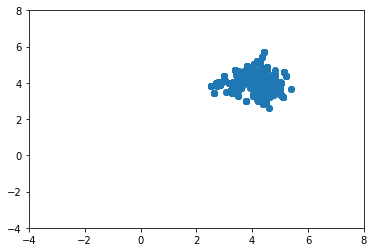

In [253]:
accepted = np.sum(success)
print('Rate of accepted trajectories: {}/{} = {}'.format(accepted, epochs, accepted/epochs))

n_samples = 1000
fig = plt.figure()
last_trial = trial[len(trial)-n_samples:]
x = last_trial[:,0]
y = last_trial[:,1]

n_bins = 50
hist, xedges, yedges = np.histogram2d(x, y, bins= n_bins)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()

z = np.reshape(hist.ravel(), (n_bins, n_bins))
xmin = np.min(xedges)
xmax = np.max(xedges)
ymin = np.min(yedges) 
ymax = np.max(yedges)

#im = plt.imshow(z, cmap = 'Reds', extent = [xmin, xmax, ymin, ymax], aspect = 1)
#plt.colorbar(im)
plt.scatter(x, y)
plt.xlim([-4, 8])
plt.ylim([-4,8])

### Plot
plot a comparison between the original landscape and the reconstructed one with monte carlo. 
ONLY AVAILABLE FOR DIMENSIONS = 2

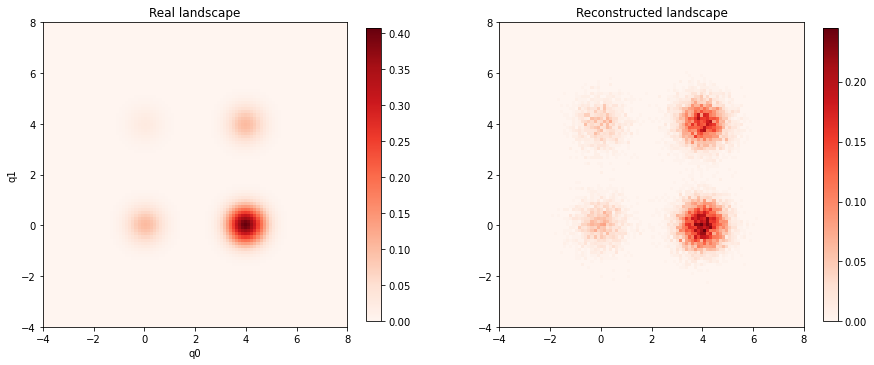

In [254]:
%matplotlib inline

trial = np.array(trial)
lines = np.linspace(-4,8,1000)

trial_accepted = trial[success == True]

#3d plots of the reconstructed landscape
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x = trial_accepted[:,0]
    y = trial_accepted[:,1]

    hist, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[-4, 8], [-4, 8]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.1, yedges[:-1] + 0.1, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    plt.show()
    
#2d plots
if True:
    #------------ FIRST PLOT ------------------#
    x = np.linspace(-4, 8, 100)
    y = np.linspace(-4, 8, 100)
    X, Y = np.meshgrid(x, y)
    Z1 = func(X)
    Z2 = func(Y)
    Z = Z1*Z2

    fig, axes = plt.subplots(1, 2, figsize = (15, 9))
    ax1 = axes[0]
    ax2 = axes[1]

    ax1.set_xlabel('q0')
    ax1.set_ylabel('q1')
    
    #CS = ax1.contour(X, Y, Z, cmap = 'Blues')
    #ax1.clabel(CS, levels = [.12, .24, .3], inline=True, fontsize=10)
    
    im = ax1.imshow(Z, cmap = 'Reds', extent = [-4, 8, -4, 8], aspect = 1)
    ax1.set_title('Real landscape'.format(how_many_traj))
    plt.colorbar(im, ax = ax1, shrink = .6)
    
    #------------ SECOND PLOT ------------------#
    x = trial_accepted[:,0]
    y = trial_accepted[:,1]

    hist,_,_ = np.histogram2d(x, y, bins=100, range=[[-4, 8], [-4, 8]], density = True)
    z = np.reshape(hist.ravel(), (100,100))
    im2 = ax2.imshow(z, cmap = 'Reds', extent = [-4, 8, -4, 8], aspect = 1)
    plt.title('Reconstructed landscape')
    plt.colorbar(im2, ax = ax2, shrink = .6)